In [15]:
import numpy as np
import pandas as pd
from scraper import StockInfo
import json
import matplotlib.pyplot as plt
import math

In [174]:
ticker = "NVDA"
tick = StockInfo(ticker)
df = pd.read_csv('csv/tickers.csv')
f = open('jsons/valJSON.json')
data = json.loads(json.loads(f.read()))

data = data[ticker]
price = tick.get_marketStockPrice()

[*********************100%***********************]  1 of 1 completed


In [175]:
def remap( x, oMin, oMax, nMin, nMax ):
    reverseInput = False
    oldMin = min( oMin, oMax )
    oldMax = max( oMin, oMax )
    if not oldMin == oMin:
        reverseInput = True

    reverseOutput = False   
    newMin = min( nMin, nMax )
    newMax = max( nMin, nMax )
    if not newMin == nMin :
        reverseOutput = True

    portion = (x-oldMin)*(newMax-newMin)/(oldMax-oldMin)
    if reverseInput:
        portion = (oldMax-x)*(newMax-newMin)/(oldMax-oldMin)

    result = portion + newMin
    if reverseOutput:
        result = newMax - portion

    return result

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def centerData(mean, data):
    data = data - mean
    return data

In [176]:
prob = data["y"] / np.sum(data["y"])
x = data["x"]
mux, sd = weighted_avg_and_std(data["x"], prob)
x = np.array([-1 + 2 * (z - min(x)) / (max(x) - min(x)) for z in x])
meanx, stdx = weighted_avg_and_std(x, prob)
x = x - meanx
mux

333.01014035331815

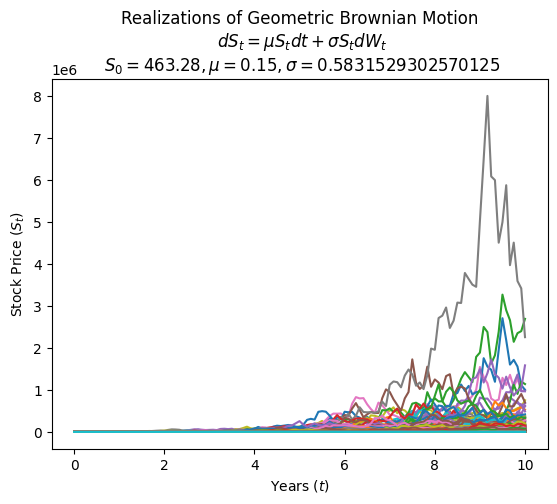

In [177]:
# drift coefficent
mu = 0.15
# time in years
T = 10
# number of steps
n = 12 * T
# number of sims
M = 10000
# initial stock price
S0 = price
# volatility
sigma = np.std(x)
# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.choice(x, p=prob, size=(M, n)).T 
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
St = S0 * St.cumprod(axis=0)

# Define time interval correctly
time = np.linspace(0,T,n+1)
# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt, St)
plt.xlabel("Years $(t)$")

plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(S0, mu, sigma)
)
plt.show()

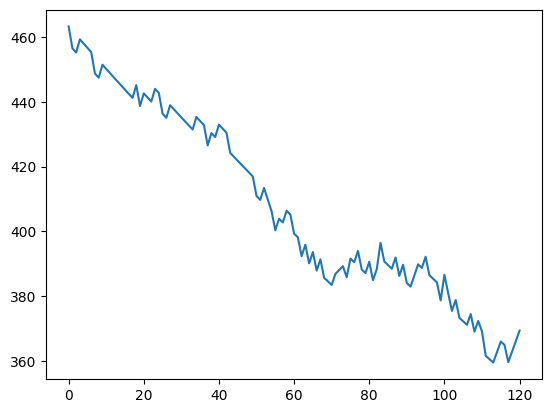

In [178]:
gbm90 = []
gbm10 = []
meanGBM = []
for i in range(len(St)):
    gbm90.append(np.percentile(St[i], 90))
    gbm10.append(np.percentile(St[i], 25))
    meanGBM.append(np.percentile(St[i], 50))
    
plt.plot(meanGBM)
#plt.plot(gbm90)
#plt.plot(gbm10)